In [1]:
!pip install timm
!pip install lightning
!pip install astropy
import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import sys
sys.path.append('/content/')

from dataloader_fits import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

zip_path = '/content/drive/MyDrive/Dataset/aia_synoptic_copy_1.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [2]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 10
batch_size = 2
learning_rate = 0.001
dropout = 0.5
lstm_layers = 2

k_folds = 5

In [3]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

In [4]:
dataset = SunImageDataset(csv_file="/content/dataset_full_2024_with_cr_2days.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size-24]
k_fold_2_indices = indices[fold_size+24:(2*fold_size)-24]
k_fold_3_indices = indices[(2*fold_size)+24:(3*fold_size)-24]
k_fold_4_indices = indices[(3*fold_size)+24:(4*fold_size)-24]
k_fold_5_indices = indices[(4*fold_size)+24:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list
kp_dates = pd.read_csv("/content/matched_kp_dates_full_2024_with_cr_2days.csv")
kp_dates_list = kp_dates["date"].tolist()

1869
1845
1845
1845
1872


In [5]:
# Get active indices
dataset_csv_file = pd.read_csv("/content/dataset_full_2024_with_cr_2days.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)

active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))

for dataloader in active_dataloaders:
    print(len(dataloader))

463
634
608
304
601


In [6]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()

        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)

        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )


        self.lstm = nn.LSTM(hidden_size, hidden_size * 2, lstm_layers, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_size*2, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            # nn.LeakyReLU()

        )

    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """

        batch_size = images.shape[0]

        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, 10, -1)

        # hidden_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # cell_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # image_features, _ = self.lstm(image_features, (hidden_states, cell_states))
        image_features, _ = self.lstm(image_features)

        image_features = image_features[:, -1, :]
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()

In [7]:
torch.cuda.empty_cache()

In [8]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1

    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):

    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss

def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1





In [9]:
def train_model(fabric):
  print(fabric.device)
  total_avg_test_loss = 0
  total_rmse = 0
  total_mse = 0
  total_mae = 0
  total_r2 = 0
  total_r = 0
  total_tts = 0
  total_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0

  active_total_avg_test_loss = 0
  active_total_rmse = 0
  active_total_mse = 0
  active_total_mae = 0
  active_total_r2 = 0
  active_total_r = 0


  for i in range(k_folds):
      print(f'FOLD {i + 1}')
      print('--------------------------------')
      test_indices = dataloaders[i]
      active_test_indices = active_dataloaders[i]
      train_indices = []
      for j in range(k_folds):
          if j != i:
              train_indices += dataloaders[j]

      trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=20, prefetch_factor=6, pin_memory=True, worker_init_fn=lambda _: np.random.seed(42))
      testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      trainloader = fabric.setup_dataloaders(trainloader)
      testloader = fabric.setup_dataloaders(testloader)
      active_testloader = fabric.setup_dataloaders(active_testloader)


      # Reinitialize model
      model = GmiSwinTransformer(hidden_size=hidden_size)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      model, optimizer = fabric.setup(model, optimizer)
      model.train()

      # Training the model
      n_total_steps = len(trainloader)
      avg_train_loss_over_epochs = []
      avg_val_loss_over_epochs = []

      for epoch in range(num_epochs):
          train_losses = []
          val_losses = []

          # Training loop
          model.train()
          for i, (images, labels) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
              # Move images and labels to device
              images = images.float()
              labels = labels.float()

              # Forward pass with autograd
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

              # Backward pass and optimization
              optimizer.zero_grad()
              fabric.backward(loss)
              optimizer.step()
              # Store the loss
              train_losses.append(loss.item())

          # Store the average training loss for this epoch
          avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
          print("Average Training Loss: ", sum(train_losses) / len(train_losses))

          # Validation loop
          model.eval()
          with torch.no_grad():
              for images, labels in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                  images = images.float()
                  # images = images.permute(1, 0, 2, 3, 4)
                  labels = labels.float()
                  outputs = model(images).squeeze(1)
                  loss = criterion(outputs, labels)
                  # print("Validation Loss: ", loss.item())
                  val_losses.append(loss.item())

          # Store the average validation loss for this epoch
          avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
          print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

      # Plot loss over epochs
      plt.figure()
      plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
      plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
      plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
      plt.xlabel('Epoch')
      plt.ylabel('Average Loss')
      plt.legend()
      plt.title('Training and Validation Loss Over Epochs')
      plt.show()

      test_losses = []
      all_labels = []
      all_outputs = []

      model.eval()

      print('--------------------------------')
      print('Test for Full set')
      print('--------------------------------')

  # Test for Full set
      with torch.no_grad():
          for images, labels in tqdm(testloader, desc="Testing Progress"):
              images = images.float()
              # images = images.permute(1, 0, 2, 3, 4)
              labels = labels.float()
              # print("Label: ", labels)
              outputs = model(images).squeeze(1)
              # print("Output: ", outputs)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      total_avg_test_loss += avg_test_loss
      total_rmse += rmse
      total_mse += mse
      total_mae += mae
      total_r2 += r2
      total_r += r
      total_tts += tts
      total_accuracy += accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1


      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')

      test_dates = list(kp_dates_list[i] for i in test_indices)
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
      plt.plot([0, len(test_dates)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')
      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Format x-axis with dates
      test_dates_sliced = test_dates[0:len(all_labels):20]
      plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Date', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)

      print('--------------------------------')
      print('Test for Active Periods')
      print('--------------------------------')

      test_losses = []
      all_labels = []
      all_outputs = []

  # Test for active periods
      with torch.no_grad():
          for images, labels in tqdm(active_testloader, desc="Testing Progress"):
              images = images.float()
              labels = labels.float()
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)



      # Accumulate metrics for averaging across folds
      active_total_avg_test_loss += avg_test_loss
      active_total_rmse += rmse
      active_total_mse += mse
      active_total_mae += mae
      active_total_r2 += r2
      active_total_r += r




      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with a window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')

      plt.plot([0, len(all_labels)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')

      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Sample Index', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)


  print('--------------------------------')
  print('Metrics for Full Set')
  print('--------------------------------')

  # Average metrics across all folds
  total_avg_test_loss /= k_folds
  total_rmse /= k_folds
  total_mse /= k_folds
  total_mae /= k_folds
  total_r2 /= k_folds
  total_r /= k_folds
  total_tts /= k_folds
  total_accuracy /= k_folds
  total_precision /= k_folds
  total_recall /= k_folds
  total_f1 /= k_folds

  print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
  print(f'Average RMSE across all folds: {total_rmse:.4f}')
  print(f'Average MSE across all folds: {total_mse:.4f}')
  print(f'Average MAE across all folds: {total_mae:.4f}')
  print(f'Average R² across all folds: {total_r2:.4f}')
  print(f'Average R across all folds: {total_r:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')
  print(f'Average True Skill Score across all folds: {total_tts:.4f}')
  print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
  print(f'Average Precision across all folds: {total_precision:.4f}')
  print(f'Average Recall across all folds: {total_recall:.4f}')
  print(f'Average F1 Score across all folds: {total_f1:.4f}')

  print('--------------------------------')
  print('Metrics for Active Periods')
  print('--------------------------------')
  # Average metrics across all folds
  active_total_avg_test_loss /= k_folds
  active_total_rmse /= k_folds
  active_total_mse /= k_folds
  active_total_mae /= k_folds
  active_total_r2 /= k_folds
  active_total_r /= k_folds

  print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
  print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
  print(f'Average active MSE across all folds: {active_total_mse:.4f}')
  print(f'Average active MAE across all folds: {active_total_mae:.4f}')
  print(f'Average active R² across all folds: {active_total_r2:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')




INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0
FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  2.067391933931519


Validation Progress: Epoch: 1:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.73262327522626


Training Progress: Epoch: 2:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  1.4399595165990553


Validation Progress: Epoch: 2:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.7114304351978338


Training Progress: Epoch: 3:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  1.1051686222520503


Validation Progress: Epoch: 3:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.1675329331738236


Training Progress: Epoch: 4:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.8367447373330532


Validation Progress: Epoch: 4:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.0810569034322866


Training Progress: Epoch: 5:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.6659604321288317


Validation Progress: Epoch: 5:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.9911697618211346


Training Progress: Epoch: 6:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.5592858250128543


Validation Progress: Epoch: 6:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.9869737101094413


Training Progress: Epoch: 7:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.4590724240621405


Validation Progress: Epoch: 7:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.9231159928030668


Training Progress: Epoch: 8:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.38793157888580476


Validation Progress: Epoch: 8:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.0249193980643745


Training Progress: Epoch: 9:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.33606523538012295


Validation Progress: Epoch: 9:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.9537987536124457


Training Progress: Epoch: 10:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.31146961238640747


Validation Progress: Epoch: 10:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.1960740894524404


--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/935 [00:00<?, ?it/s]

Average test loss: 2.1961
RMSE: 1.4819
MSE: 2.1951
MAE: 1.1695
R²: -0.1422
R: 0.3343
True Skill Score: 0.3058
Accuracy: 0.7448
Precision: 0.4858
Recall: 0.5162
F1 Score: 0.5005


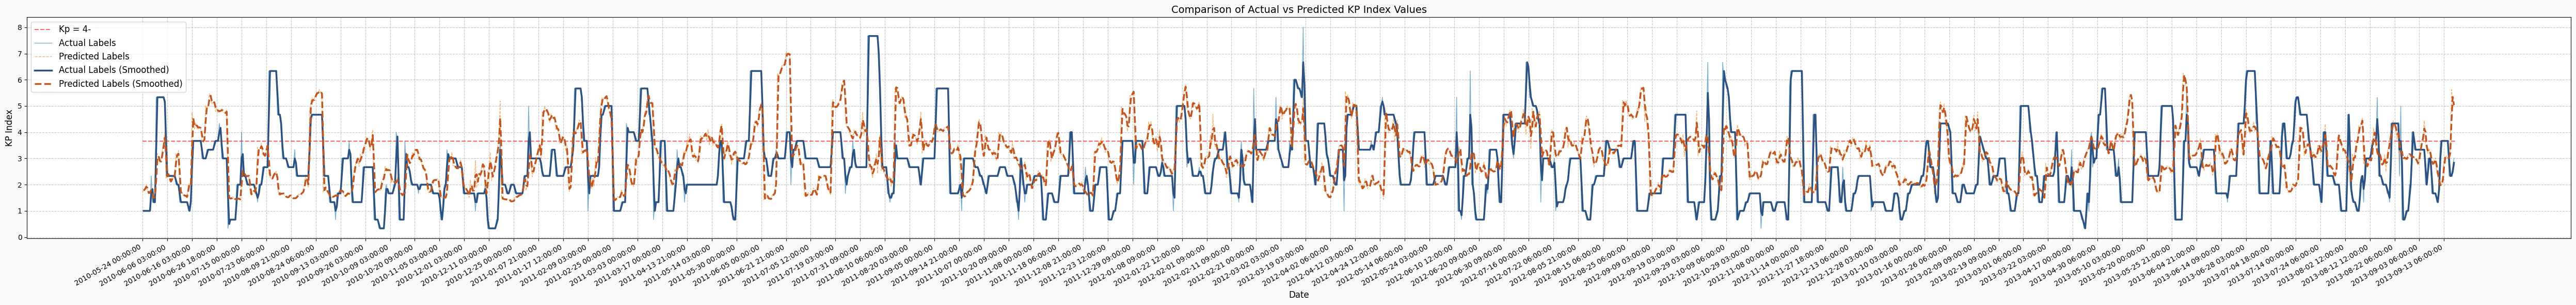

[np.float32(1.7265625), np.float32(1.8203125), np.float32(1.84375), np.float32(2.0), np.float32(1.7421875), np.float32(1.6328125), np.float32(1.7421875), np.float32(1.8359375), np.float32(1.453125), np.float32(1.53125), np.float32(1.53125), np.float32(2.796875), np.float32(3.1875), np.float32(2.984375), np.float32(2.828125), np.float32(2.9375), np.float32(3.34375), np.float32(3.578125), np.float32(4.0), np.float32(2.25), np.float32(2.375), np.float32(2.421875), np.float32(2.09375), np.float32(2.140625), np.float32(2.28125), np.float32(2.21875), np.float32(2.4375), np.float32(3.1875), np.float32(3.0625), np.float32(3.296875), np.float32(1.6953125), np.float32(1.6875), np.float32(1.71875), np.float32(1.578125), np.float32(1.5859375), np.float32(1.5546875), np.float32(1.5078125), np.float32(2.046875), np.float32(2.015625), np.float32(1.984375), np.float32(4.75), np.float32(4.3125), np.float32(4.125), np.float32(4.375), np.float32(4.125), np.float32(4.21875), np.float32(4.15625), np.float3

Testing Progress:   0%|          | 0/232 [00:00<?, ?it/s]

Average test loss: 2.8886
RMSE: 1.6996
MSE: 2.8937
MAE: 1.3330
R²: -2.1598
R: 0.0156


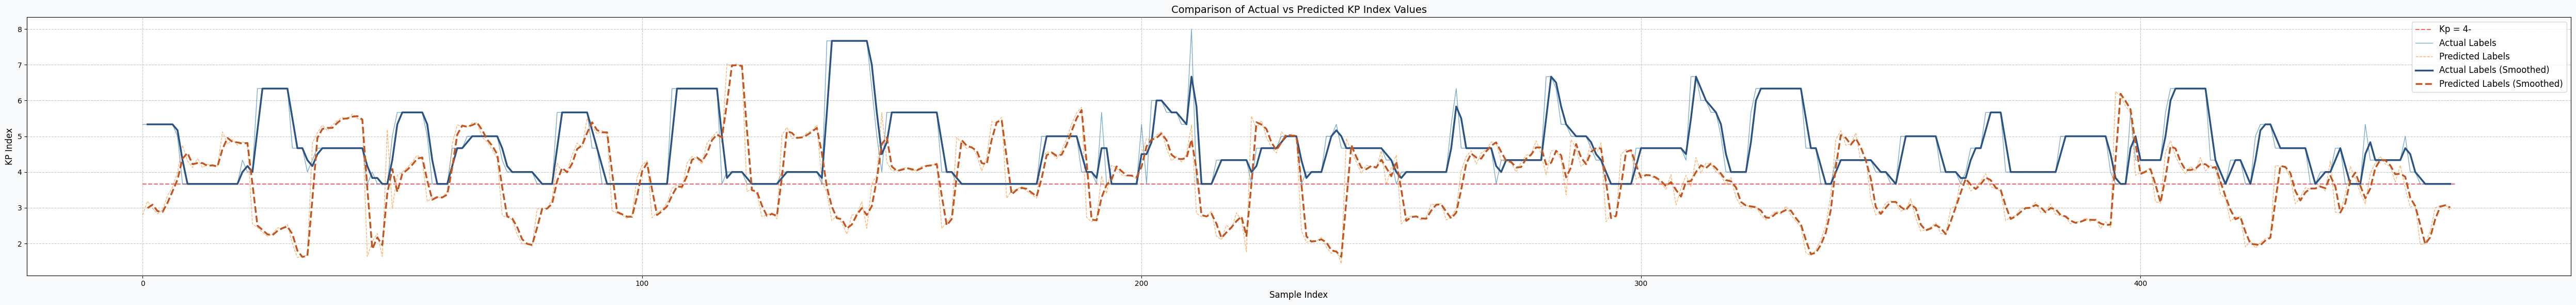

[np.float32(2.796875), np.float32(3.1875), np.float32(2.984375), np.float32(2.828125), np.float32(2.9375), np.float32(3.34375), np.float32(3.578125), np.float32(4.0), np.float32(4.75), np.float32(4.3125), np.float32(4.125), np.float32(4.375), np.float32(4.125), np.float32(4.21875), np.float32(4.15625), np.float32(4.15625), np.float32(5.125), np.float32(4.78125), np.float32(4.90625), np.float32(4.75), np.float32(4.84375), np.float32(4.78125), np.float32(2.546875), np.float32(2.453125), np.float32(2.3125), np.float32(2.203125), np.float32(2.265625), np.float32(2.4375), np.float32(2.421875), np.float32(2.53125), np.float32(1.9921875), np.float32(1.609375), np.float32(1.640625), np.float32(1.671875), np.float32(4.8125), np.float32(5.09375), np.float32(5.3125), np.float32(5.15625), np.float32(5.3125), np.float32(5.4375), np.float32(5.53125), np.float32(5.46875), np.float32(5.625), np.float32(5.5), np.float32(5.4375), np.float32(1.6328125), np.float32(2.0625), np.float32(2.28125), np.float32

Training Progress: Epoch: 1:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  2.013994635817857


Validation Progress: Epoch: 1:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.8167284175423755


Training Progress: Epoch: 2:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.3803920824726785


Validation Progress: Epoch: 2:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.9846024457988343


Training Progress: Epoch: 3:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.0465824569413797


Validation Progress: Epoch: 3:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.0587573433722937


Training Progress: Epoch: 4:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.7639917830502323


Validation Progress: Epoch: 4:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.154936464438389


Training Progress: Epoch: 5:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.6067136642653983


Validation Progress: Epoch: 5:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.9782630062732318


Training Progress: Epoch: 6:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.5016652002678545


Validation Progress: Epoch: 6:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.154650220911438


Training Progress: Epoch: 7:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.39585734061316236


Validation Progress: Epoch: 7:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.398300819157283


Training Progress: Epoch: 8:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.3918320223981484


Validation Progress: Epoch: 8:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.013047596302619


Training Progress: Epoch: 9:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.3679717875123788


Validation Progress: Epoch: 9:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.179095456762187


Training Progress: Epoch: 10:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.28280228100170895


Validation Progress: Epoch: 10:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.1187325549622966


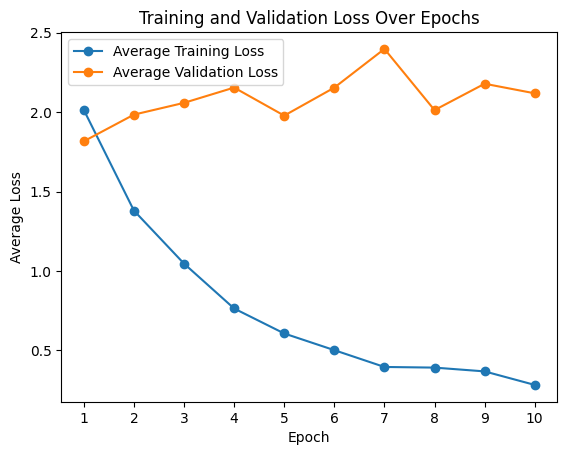

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/923 [00:00<?, ?it/s]

Average test loss: 2.1187
RMSE: 1.4556
MSE: 2.1193
MAE: 1.1550
R²: -0.1196
R: 0.2295
True Skill Score: 0.3078
Accuracy: 0.6623
Precision: 0.5109
Recall: 0.4054
F1 Score: 0.4521


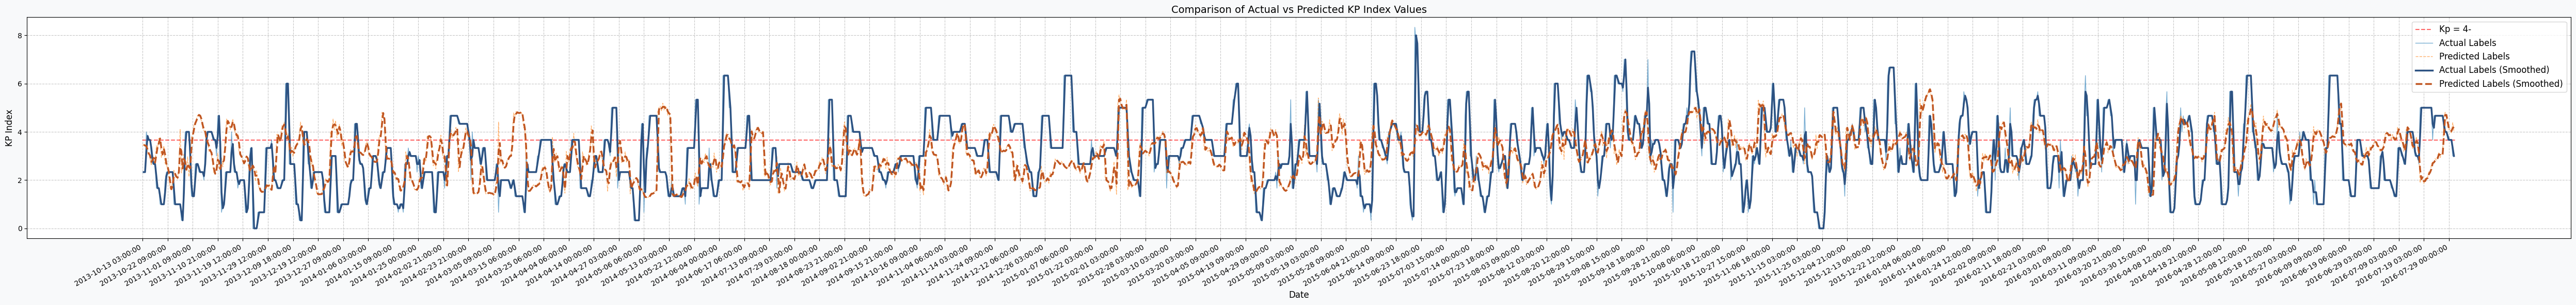

[np.float32(3.4375), np.float32(3.484375), np.float32(3.390625), np.float32(3.453125), np.float32(3.078125), np.float32(3.125), np.float32(2.90625), np.float32(2.609375), np.float32(3.0625), np.float32(2.78125), np.float32(2.671875), np.float32(3.421875), np.float32(3.328125), np.float32(3.734375), np.float32(3.71875), np.float32(2.9375), np.float32(3.1875), np.float32(3.421875), np.float32(2.6875), np.float32(2.671875), np.float32(2.453125), np.float32(2.203125), np.float32(1.65625), np.float32(1.5859375), np.float32(1.96875), np.float32(2.40625), np.float32(2.125), np.float32(2.15625), np.float32(2.046875), np.float32(2.640625), np.float32(4.09375), np.float32(2.296875), np.float32(2.671875), np.float32(3.078125), np.float32(2.46875), np.float32(2.390625), np.float32(2.96875), np.float32(2.140625), np.float32(2.84375), np.float32(3.765625), np.float32(3.90625), np.float32(4.28125), np.float32(4.40625), np.float32(4.53125), np.float32(4.6875), np.float32(4.71875), np.float32(4.625), n

Testing Progress:   0%|          | 0/317 [00:00<?, ?it/s]

Average test loss: 2.6135
RMSE: 1.6166
MSE: 2.6135
MAE: 1.2847
R²: -2.4788
R: 0.1933


[np.float32(3.75), np.float32(3.578125), np.float32(3.984375), np.float32(3.671875), np.float32(3.8125), np.float32(4.125), np.float32(3.765625), np.float32(3.9375), np.float32(3.90625), np.float32(4.1875), np.float32(4.09375), np.float32(2.359375), np.float32(2.71875), np.float32(3.3125), np.float32(3.171875), np.float32(3.515625), np.float32(3.875), np.float32(4.1875), np.float32(3.859375), np.float32(3.828125), np.float32(3.734375), np.float32(1.59375), np.float32(1.96875), np.float32(2.296875), np.float32(2.53125), np.float32(2.453125), np.float32(2.59375), np.float32(2.234375), np.float32(1.8671875), np.float32(1.609375), np.float32(1.4921875), np.float32(1.8984375), np.float32(3.390625), np.float32(3.28125), np.float32(3.9375), np.float32(3.234375), np.float32(2.953125), np.float32(2.546875), np.float32(2.53125), np.float32(2.515625), np.float32(2.375), np.float32(2.375), np.float32(1.546875), np.float32(2.734375), np.float32(2.71875), np.float32(2.953125), np.float32(2.9375), np

Training Progress: Epoch: 1:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  2.1013997741825534


Validation Progress: Epoch: 1:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.3980506508073793


Training Progress: Epoch: 2:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.5475626252450008


Validation Progress: Epoch: 2:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.3143446747431755


Training Progress: Epoch: 3:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.133738198772668


Validation Progress: Epoch: 3:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.493847190423133


Training Progress: Epoch: 4:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.8271128310958948


Validation Progress: Epoch: 4:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.5579791179671039


Training Progress: Epoch: 5:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.6302289344935273


Validation Progress: Epoch: 5:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.478657109188148


Training Progress: Epoch: 6:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.4971611768506915


Validation Progress: Epoch: 6:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.549000820777172


Training Progress: Epoch: 7:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.4205162703695344


Validation Progress: Epoch: 7:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.433266161811215


Training Progress: Epoch: 8:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.35967434364478706


Validation Progress: Epoch: 8:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.33864621260382


Training Progress: Epoch: 9:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.307953244356304


Validation Progress: Epoch: 9:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.3454673603547458


Training Progress: Epoch: 10:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.2646605512341354


Validation Progress: Epoch: 10:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.4390372757587935


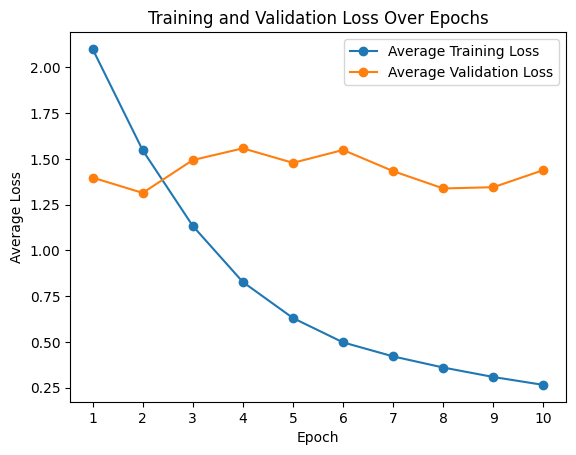

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/923 [00:00<?, ?it/s]

Average test loss: 1.4390
RMSE: 1.1996
MSE: 1.4396
MAE: 0.9529
R²: 0.1942
R: 0.4456
True Skill Score: 0.5522
Accuracy: 0.6986
Precision: 0.6193
Recall: 0.2220
F1 Score: 0.3269


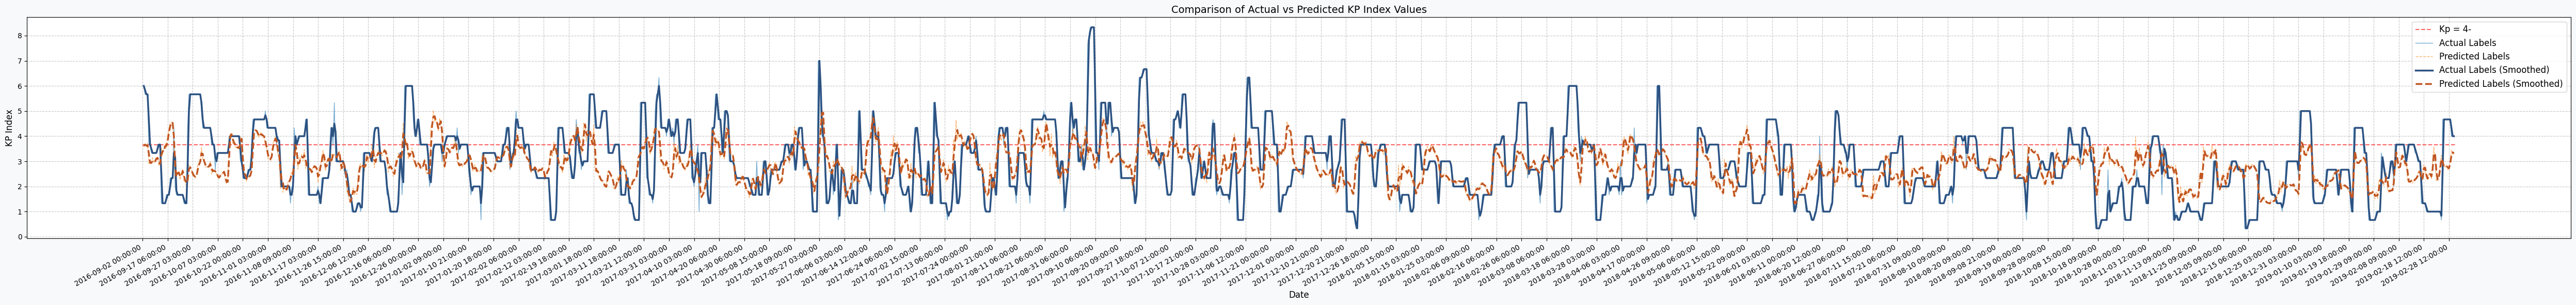

[np.float32(3.59375), np.float32(3.625), np.float32(3.703125), np.float32(3.5625), np.float32(3.71875), np.float32(2.90625), np.float32(2.984375), np.float32(2.890625), np.float32(3.140625), np.float32(2.9375), np.float32(3.0625), np.float32(3.140625), np.float32(3.140625), np.float32(2.8125), np.float32(2.984375), np.float32(3.53125), np.float32(3.28125), np.float32(3.5), np.float32(3.703125), np.float32(3.546875), np.float32(4.03125), np.float32(4.25), np.float32(4.53125), np.float32(4.5625), np.float32(4.5), np.float32(3.5), np.float32(2.28125), np.float32(2.484375), np.float32(2.578125), np.float32(2.53125), np.float32(2.265625), np.float32(2.5625), np.float32(2.671875), np.float32(2.21875), np.float32(2.265625), np.float32(2.0), np.float32(2.515625), np.float32(2.859375), np.float32(2.671875), np.float32(2.640625), np.float32(2.40625), np.float32(2.453125), np.float32(2.328125), np.float32(2.46875), np.float32(2.859375), np.float32(2.875), np.float32(3.09375), np.float32(3.546875)

Testing Progress:   0%|          | 0/304 [00:00<?, ?it/s]

Average test loss: 2.0942
RMSE: 1.4471
MSE: 2.0942
MAE: 1.1944
R²: -2.2328
R: 0.2413


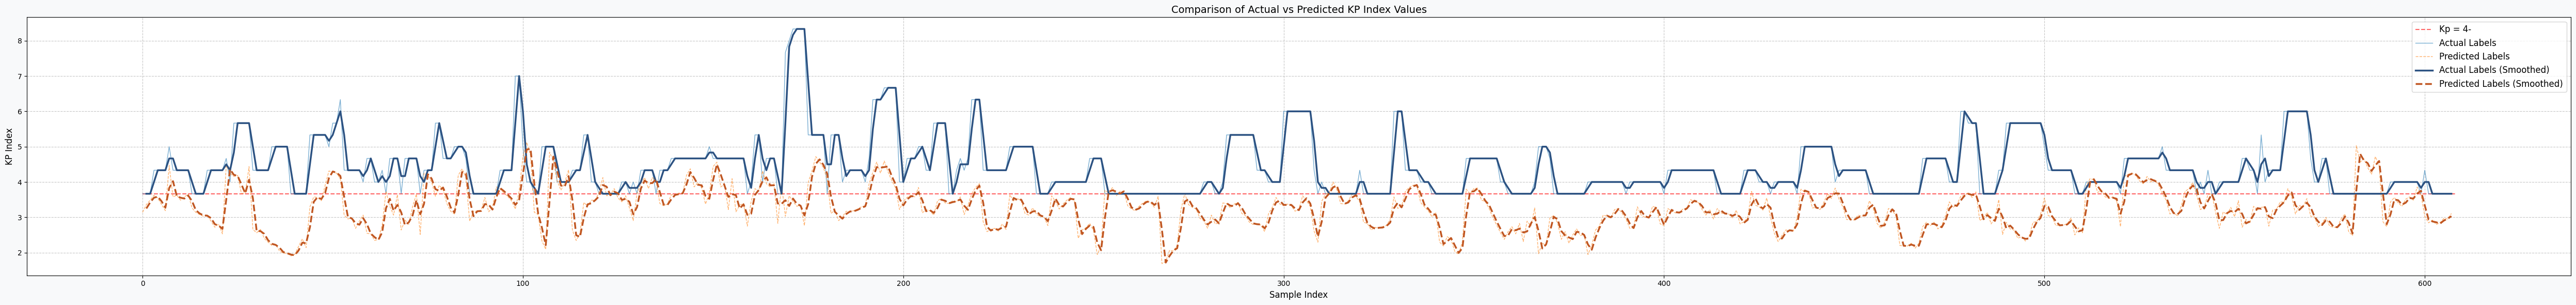

[np.float32(3.140625), np.float32(3.359375), np.float32(3.484375), np.float32(3.625), np.float32(3.546875), np.float32(3.359375), np.float32(3.1875), np.float32(4.46875), np.float32(3.578125), np.float32(3.625), np.float32(3.484375), np.float32(3.578125), np.float32(3.65625), np.float32(3.265625), np.float32(3.140625), np.float32(3.078125), np.float32(3.03125), np.float32(3.0625), np.float32(2.890625), np.float32(2.71875), np.float32(2.8125), np.float32(2.53125), np.float32(4.46875), np.float32(4.25), np.float32(4.15625), np.float32(4.1875), np.float32(3.671875), np.float32(3.6875), np.float32(4.4375), np.float32(2.65625), np.float32(2.5625), np.float32(2.65625), np.float32(2.40625), np.float32(2.296875), np.float32(2.203125), np.float32(2.234375), np.float32(2.046875), np.float32(1.984375), np.float32(1.984375), np.float32(1.90625), np.float32(1.9453125), np.float32(2.171875), np.float32(2.390625), np.float32(2.140625), np.float32(3.296875), np.float32(3.578125), np.float32(3.5625), n

Training Progress: Epoch: 1:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  2.2185281718675656


Validation Progress: Epoch: 1:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.5021961790782572


Training Progress: Epoch: 2:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.5663918798010847


Validation Progress: Epoch: 2:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.3348886285771546


Training Progress: Epoch: 3:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.2060313038859496


Validation Progress: Epoch: 3:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.4318433998683358


Training Progress: Epoch: 4:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.8820678306574739


Validation Progress: Epoch: 4:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.3876973099197853


Training Progress: Epoch: 5:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.6937778027263306


Validation Progress: Epoch: 5:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.4175512307036071


Training Progress: Epoch: 6:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.5705172246705429


Validation Progress: Epoch: 6:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.5423857379298158


Training Progress: Epoch: 7:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.5123839855320861


Validation Progress: Epoch: 7:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.5220765295798058


Training Progress: Epoch: 8:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.4127143497572816


Validation Progress: Epoch: 8:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.4361791301384732


Training Progress: Epoch: 9:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.34796252488880425


Validation Progress: Epoch: 9:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.6010518023576366


Training Progress: Epoch: 10:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.31492907066688974


Validation Progress: Epoch: 10:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.6120574357807143


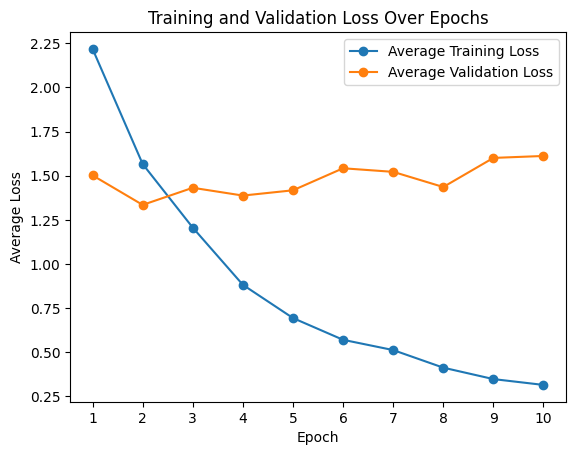

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/923 [00:00<?, ?it/s]

Average test loss: 1.6121
RMSE: 1.2697
MSE: 1.6123
MAE: 0.9243
R²: -0.1495
R: 0.3515
True Skill Score: 0.3315
Accuracy: 0.8190
Precision: 0.3828
Recall: 0.1612
F1 Score: 0.2269


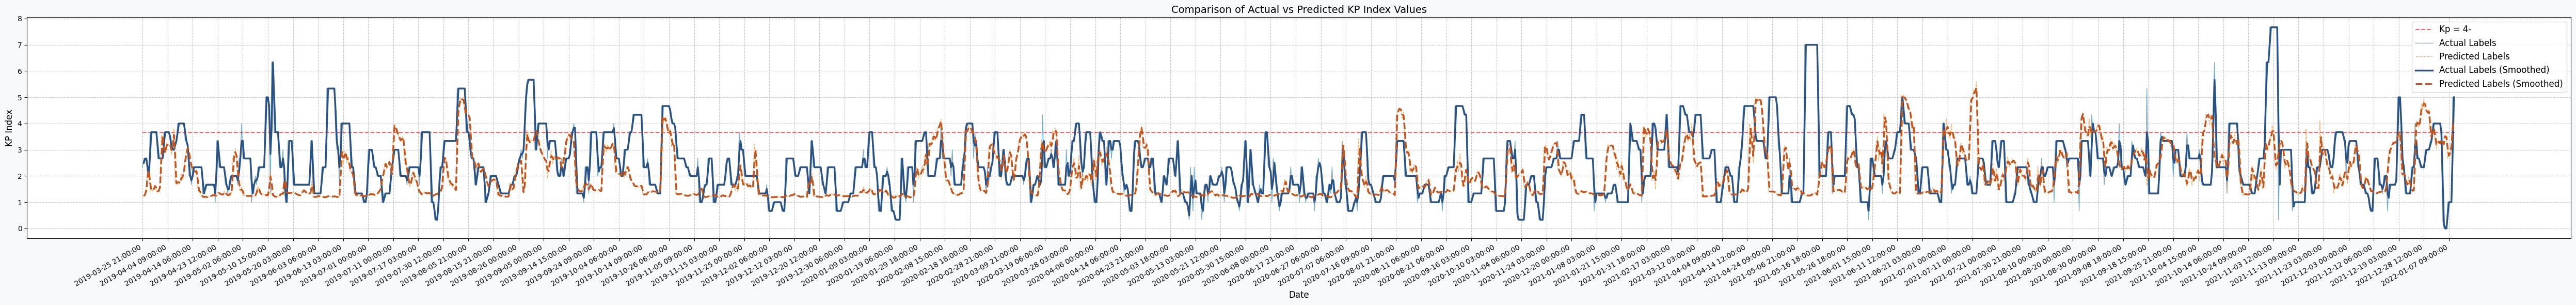

[np.float32(1.1875), np.float32(1.2890625), np.float32(1.2890625), np.float32(1.6328125), np.float32(2.25), np.float32(2.140625), np.float32(1.40625), np.float32(1.5078125), np.float32(1.4296875), np.float32(1.5703125), np.float32(1.6640625), np.float32(1.40625), np.float32(1.4296875), np.float32(1.4375), np.float32(1.7734375), np.float32(3.5625), np.float32(3.46875), np.float32(2.796875), np.float32(2.953125), np.float32(3.265625), np.float32(3.1875), np.float32(3.203125), np.float32(3.1875), np.float32(2.796875), np.float32(3.328125), np.float32(3.796875), np.float32(1.7734375), np.float32(1.6796875), np.float32(1.8046875), np.float32(1.71875), np.float32(1.75), np.float32(2.09375), np.float32(1.8671875), np.float32(2.359375), np.float32(2.765625), np.float32(2.921875), np.float32(3.203125), np.float32(2.6875), np.float32(2.546875), np.float32(2.234375), np.float32(2.3125), np.float32(2.140625), np.float32(2.171875), np.float32(2.203125), np.float32(1.5390625), np.float32(1.3828125),

Testing Progress:   0%|          | 0/152 [00:00<?, ?it/s]

Average test loss: 5.3453
RMSE: 2.3120
MSE: 5.3453
MAE: 1.8819
R²: -4.9872
R: -0.0105


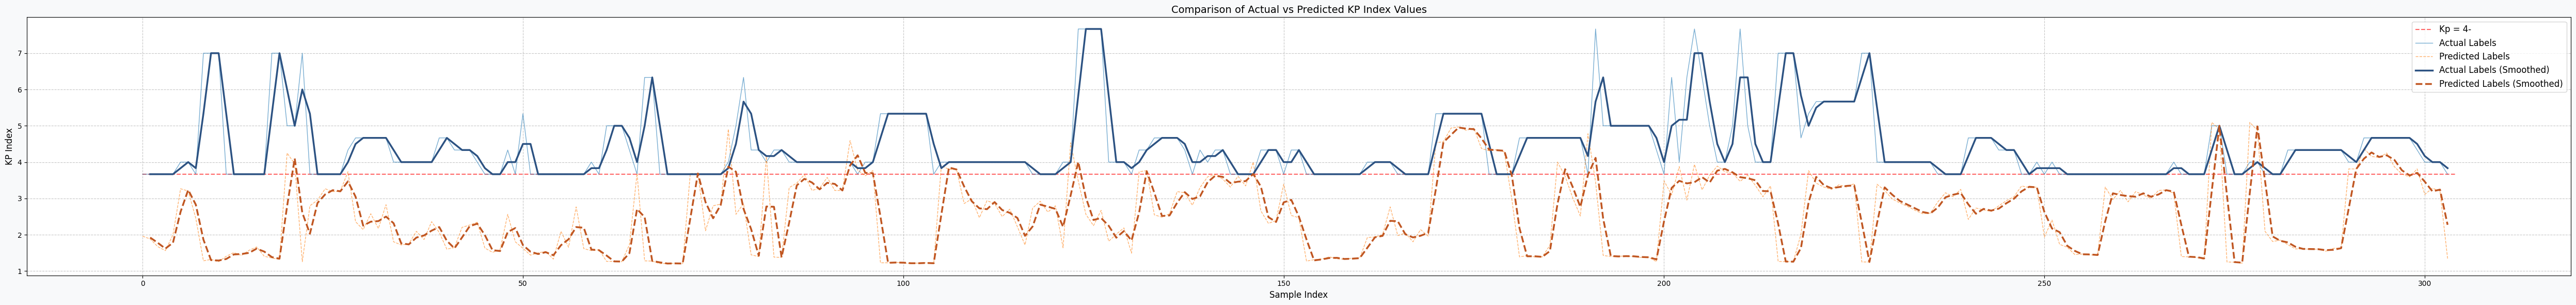

[np.float32(1.9609375), np.float32(1.8828125), np.float32(1.671875), np.float32(1.5625), np.float32(2.0), np.float32(3.265625), np.float32(3.203125), np.float32(2.453125), np.float32(1.28125), np.float32(1.3203125), np.float32(1.2578125), np.float32(1.40625), np.float32(1.5078125), np.float32(1.4296875), np.float32(1.5703125), np.float32(1.6640625), np.float32(1.40625), np.float32(1.359375), np.float32(1.3203125), np.float32(4.25), np.float32(3.953125), np.float32(1.2578125), np.float32(2.796875), np.float32(2.953125), np.float32(3.265625), np.float32(3.1875), np.float32(3.203125), np.float32(3.734375), np.float32(2.359375), np.float32(2.140625), np.float32(2.578125), np.float32(2.171875), np.float32(2.828125), np.float32(1.8046875), np.float32(1.71875), np.float32(1.75), np.float32(2.09375), np.float32(1.8671875), np.float32(2.359375), np.float32(2.0625), np.float32(1.6015625), np.float32(1.6484375), np.float32(2.203125), np.float32(2.265625), np.float32(2.34375), np.float32(1.6328125

Training Progress: Epoch: 1:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  1.936303623476766


Validation Progress: Epoch: 1:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.622051144262685


Training Progress: Epoch: 2:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  1.340981898773895


Validation Progress: Epoch: 2:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.7441421196860545


Training Progress: Epoch: 3:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.9999578251942214


Validation Progress: Epoch: 3:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.3813949999824597


Training Progress: Epoch: 4:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.7543472942674455


Validation Progress: Epoch: 4:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.5149734159591453


Training Progress: Epoch: 5:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.5908038691370759


Validation Progress: Epoch: 5:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  3.0547630621415056


Training Progress: Epoch: 6:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.4681879468809052


Validation Progress: Epoch: 6:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.796286887149598


Training Progress: Epoch: 7:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.40769082541589


Validation Progress: Epoch: 7:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  3.459135087375364


Training Progress: Epoch: 8:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.34119001383976283


Validation Progress: Epoch: 8:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.539941994108234


Training Progress: Epoch: 9:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.29066144521345655


Validation Progress: Epoch: 9:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.7183764134809816


Training Progress: Epoch: 10:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.26000662866086693


Validation Progress: Epoch: 10:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.7084925479661615


--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/936 [00:00<?, ?it/s]

Average test loss: 2.7085
RMSE: 1.6457
MSE: 2.7085
MAE: 1.2100
R²: -0.2780
R: 0.1766
True Skill Score: 0.3559
Accuracy: 0.6736
Precision: 0.4842
Recall: 0.2546
F1 Score: 0.3337


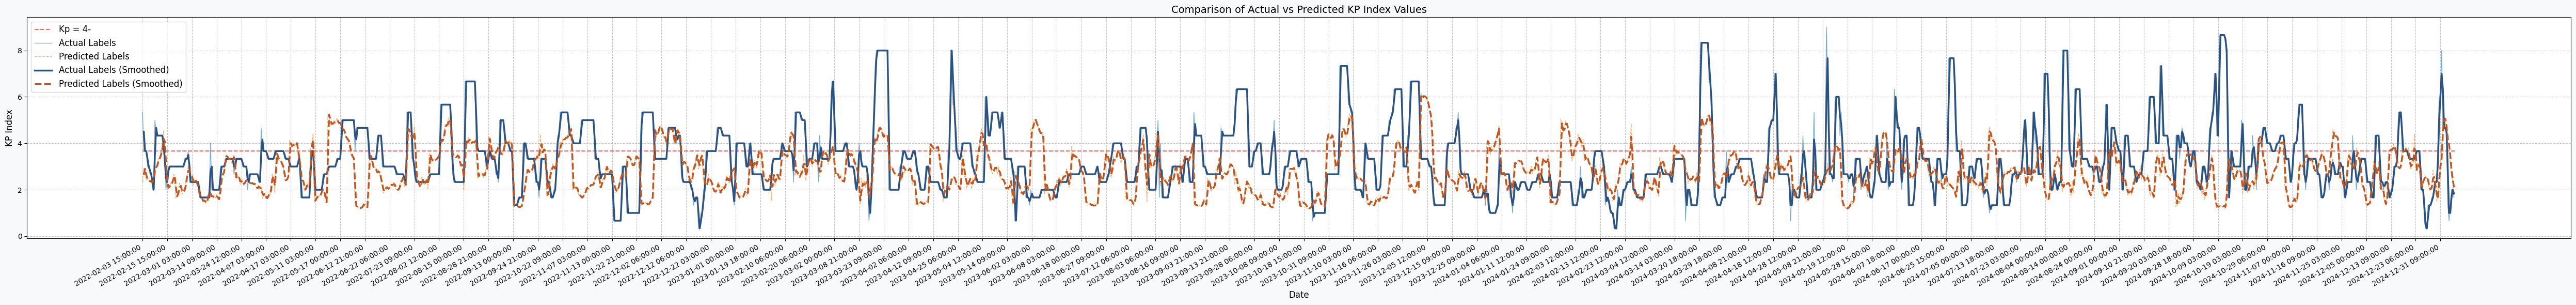

[np.float32(2.328125), np.float32(2.953125), np.float32(2.84375), np.float32(2.4375), np.float32(2.484375), np.float32(2.421875), np.float32(2.3125), np.float32(2.390625), np.float32(2.25), np.float32(2.625), np.float32(2.96875), np.float32(2.9375), np.float32(3.171875), np.float32(3.328125), np.float32(3.390625), np.float32(3.640625), np.float32(3.875), np.float32(4.53125), np.float32(3.640625), np.float32(2.640625), np.float32(2.09375), np.float32(2.078125), np.float32(2.203125), np.float32(2.34375), np.float32(2.25), np.float32(2.65625), np.float32(2.546875), np.float32(1.65625), np.float32(1.78125), np.float32(1.9140625), np.float32(2.28125), np.float32(2.046875), np.float32(1.796875), np.float32(2.046875), np.float32(1.8984375), np.float32(2.453125), np.float32(2.59375), np.float32(3.03125), np.float32(2.625), np.float32(2.609375), np.float32(2.5625), np.float32(2.21875), np.float32(2.4375), np.float32(2.40625), np.float32(2.21875), np.float32(2.078125), np.float32(1.6796875), np.

Testing Progress:   0%|          | 0/301 [00:00<?, ?it/s]

Average test loss: 6.0024
RMSE: 2.4500
MSE: 5.9913
MAE: 1.9911
R²: -2.7944
R: 0.1568


[np.float32(4.71875), np.float32(4.625), np.float32(4.5625), np.float32(4.28125), np.float32(4.28125), np.float32(4.40625), np.float32(4.34375), np.float32(4.34375), np.float32(2.9375), np.float32(3.0625), np.float32(2.75), np.float32(2.203125), np.float32(2.359375), np.float32(2.40625), np.float32(2.046875), np.float32(1.96875), np.float32(2.453125), np.float32(2.4375), np.float32(2.5), np.float32(2.609375), np.float32(2.234375), np.float32(2.25), np.float32(3.28125), np.float32(3.484375), np.float32(2.53125), np.float32(2.640625), np.float32(2.0625), np.float32(2.265625), np.float32(2.421875), np.float32(2.53125), np.float32(4.21875), np.float32(3.8125), np.float32(3.359375), np.float32(3.453125), np.float32(2.9375), np.float32(2.890625), np.float32(2.6875), np.float32(2.90625), np.float32(2.96875), np.float32(2.9375), np.float32(2.671875), np.float32(2.984375), np.float32(2.546875), np.float32(2.484375), np.float32(2.421875), np.float32(3.15625), np.float32(3.421875), np.float32(3.1

In [10]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch(train_model)

In [11]:
# prompt: disconnect runtime
import time
time.sleep(5 * 60)
from google.colab import runtime
runtime.unassign()
